#### running GPFA on MC maze dataset

In [12]:
# imports
import neo
import h5py
import torch
import pickle
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange

import quantities as pq
from elephant.gpfa import GPFA

In [2]:
# loading train data
trial_info_save_path = 'data/info_per_trial_{}.pkl'
spikes_per_trial_save_path = 'data/spikes_per_trial.h5'
rates_per_trial_save_path = 'data/rates_per_trial_{}.npy'
velocity_per_trial_save_path = 'data/velocity_per_trial_{}.npy'
position_per_trial_save_path = 'data/position_per_trial_{}.npy'

spikes_per_trial = h5py.File(spikes_per_trial_save_path, 'r')
spike_data_train = np.array(spikes_per_trial['Y'], np.float32)
spike_data_val = np.array(spikes_per_trial['Y_val'], np.float32)
# print(spike_data_train.shape)

position_per_trial_train = np.load(position_per_trial_save_path.format("train"))
velocity_per_trial_train = np.load(velocity_per_trial_save_path.format("train"))
rates_per_trial_train = np.load(rates_per_trial_save_path.format("train"))

trial_info_train = []
with (open(trial_info_save_path.format("train"), "rb")) as openfile:
    while True:
        try:
            trial_info_train.append(pickle.load(openfile))
        except EOFError:
            break
trial_info_train = trial_info_train[0]

In [3]:
# Convert to neo.SpikeTrains
def array_to_spiketrains(array, bin_size):
    """Convert B x T x N spiking array to list of list of SpikeTrains"""
    stList = []
    for trial in range(len(array)):
        trialList = []
        for channel in range(array.shape[2]):
            times = np.nonzero(array[trial, :, channel])[0]
            counts = array[trial, times, channel].astype(int)
            times = np.repeat(times, counts)
            st = neo.SpikeTrain(times*bin_size*pq.ms, t_stop=array.shape[1]*bin_size*pq.ms)
            trialList.append(st)
        stList.append(trialList)
    return stList

In [4]:
# setting up some parameters for the GPFA
bin_size_ms = 5
n_latents = 2
bin_size_ms_q = bin_size_ms * pq.ms

In [5]:
# setting up train data
train_spikes = array_to_spiketrains(spike_data_train, bin_size_ms)
val_spikes = array_to_spiketrains(spike_data_val, bin_size_ms)

In [6]:
# Run GPFA
gpfa = GPFA(bin_size=bin_size_ms_q, x_dim=n_latents)
train_factors = gpfa.fit_transform(train_spikes)
val_factors = gpfa.transform(val_spikes)

Initializing parameters using factor analysis...

Fitting GPFA model...


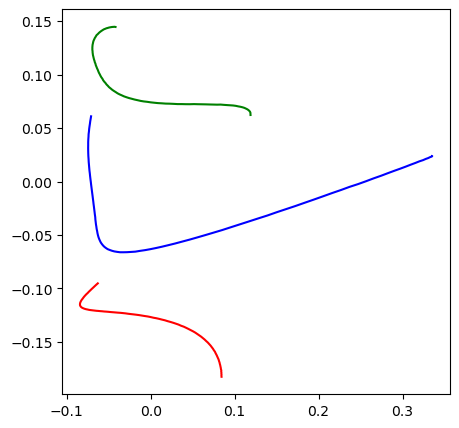

In [7]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
_=ax.plot(np.array(train_factors[0][0,:]), np.array(train_factors[0][1,:]), color='blue')
_=ax.plot(np.array(train_factors[1][0,:]), np.array(train_factors[1][1,:]), color='red')
_=ax.plot(np.array(train_factors[2][0,:]), np.array(train_factors[2][1,:]), color='green')